In [38]:
#importing libraries

import random as rd
import hashlib
import phe
import rsa
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer


In [39]:
#declaring of varibles
numberOfExperts = 0
numberOfCandidates = 0
keySize = 0
#collection of homomophic public and private keys
dictionaryOfExpertPublicKeys = {}
dictionaryOfExpertPrivateKeys = {}

dictionaryOfCandidatesPublicKeys = {}
dictionaryOfCandidatesPrivateKeys = {}

#Variables for third framework@
dictionaryOfRandomNumberPerExpert = {}
dictionaryOftheSumOfRandomNumbermappedToEveryCandidate = {}
dictionaryOfRandomNumberGatheredFromOtherExperts = {}
dictionaryOfRandomNumberMappedToEveryCandidate = {}

#Collection of rsa public and private keys for digital signature
dictOfrsaPubKey = {}
dictOfrsaPriKey = {}
marksToCandidates = []


In [40]:
def initVariables(E, C, key):
    global numberOfExperts, numberOfCandidates,keySize
    numberOfExperts, numberOfCandidates,keySize = E, C, key

In [41]:
#this part of the code create the public and private homomorphic key pairs
def generateHomomorphickeyPairs():
    global publicKeyEmployer,privateKeyEmployer
    publicKeyEmployer,privateKeyEmployer = phe.generate_paillier_keypair(n_length=keySize)
    for i in range(numberOfExperts):
        x,y = phe.generate_paillier_keypair(n_length=keySize)
        dictionaryOfExpertPublicKeys[i] = x
        dictionaryOfExpertPrivateKeys[i] = y
        
    for i in range(numberOfCandidates):
        x,y = phe.generate_paillier_keypair(n_length=keySize)
        dictionaryOfCandidatesPublicKeys[i]= x
        dictionaryOfCandidatesPrivateKeys[i] = y 


In [42]:
#code to generate rsa public and private keys
def generateRSAKeys():
    global dictOfrsaPubKey, dicOfrsaPriKey
    for i in range(numberOfExperts):
        (pubkey, privkey) = rsa.newkeys(512)
        dictOfrsaPubKey[i],dictOfrsaPriKey[i] = pubkey, privkey 

In [43]:
# function to create digital signature
def createDigitalSignature(message,i):
    privkey = dictOfrsaPriKey[i]
    temp = str(message).encode()
    signature = rsa.sign(temp, privkey, 'SHA-1')
    return signature

In [44]:
def generateRandomNumberForEveryExpert():
    # global dictionaryOfRandomNumberPerExpert
    generatedRandomNumbers = [rd.randint(0,100) for x in range(numberOfExperts)]
    # print(generatedRandomNumbers)
    return generatedRandomNumbers
    # print(dictionaryOfSumGeneratedPerRandomNumber)

In [45]:
def forwardTheRespectiveRandomNumbers(idR,generatedRandomNumbers):
    encryptedRandomNumber = dictionaryOfExpertPublicKeys[idR].raw_encrypt(generatedRandomNumbers[idR])
    message = encryptedRandomNumber
    return message
# ,createDigitalSignature(encryptedRandomNumber,idS)

In [46]:
def performSMPCBetweenExperts():
    #this part of the code simulates the part where expert follow the smpc process
    #the random number assgned by all the experts has been mapped for every candidate
    # here the outer loop shows for which candidate the random number are being genereated and jth looop shows expert j is generating the random number for expert k and and passing it to expert k
    
    for i in range(numberOfCandidates):
        matrixOfForwardedMessages = [[0 for i in range(numberOfExperts)] for j in range(numberOfExperts)]
        sumList = []
        for j in range(numberOfExperts):
            generatedRandomNumbers = generateRandomNumberForEveryExpert()
            sumOfTheRandomNumbers = sum(generatedRandomNumbers) 
            sumList.append(sumOfTheRandomNumbers)

            for k in range(numberOfExperts):
                if(j != k):
                    message = forwardTheRespectiveRandomNumbers(k,generatedRandomNumbers)
                    matrixOfForwardedMessages[j][k] = message
                else:
                    # matrixOfForwardedMessages consist all random number such that from expert j to expert k
                    matrixOfForwardedMessages[j][k] = generatedRandomNumbers[j]
        dictionaryOfRandomNumberMappedToEveryCandidate[i] = matrixOfForwardedMessages
        dictionaryOftheSumOfRandomNumbermappedToEveryCandidate[i] = sumList
    # print(dictionaryOfRandomNumberMappedToEveryCandidate)
    # print(dictionaryOftheSumOfRandomNumbermappedToEveryCandidate)
    # print(dictionaryOfSumGeneratedPerRandomNumber)
    

    

In [47]:
# here in this code the outer lopp shows for whom the marks are being given , innner j loop shows expert j is giving the marks and kth loop shows other experts whp sent random number to j in smpc fuicntion
def generateHiddenScoreFrameWork3():
    global marksToCandidates
    marksToCandidates = [[0 for i in range(numberOfCandidates)] for j in range(numberOfExperts)]
    for i in range(numberOfCandidates):
        for j in range(numberOfExperts):
            mark = rd.randint(0,10)
            hiddenScore = mark + dictionaryOftheSumOfRandomNumbermappedToEveryCandidate[i][j]
            sum  = 0
            for k in range(numberOfExperts):
                if(j != k):
                    encryptedRandomNumber = dictionaryOfRandomNumberMappedToEveryCandidate[i][k][j]
                    # print(encryptedRandomNumber)
                    sum  = sum + dictionaryOfExpertPrivateKeys[j].raw_decrypt(encryptedRandomNumber)
                else: 
                    sum = sum + dictionaryOfRandomNumberMappedToEveryCandidate[i][j][j]
            hiddenScore  = hiddenScore -sum
            # print(hiddenScore)
            # marksToCandidates contains matrix where j is the expert and i is candidate and what j gave to i isthe entry
            marksToCandidates[j][i] = [hiddenScore, createDigitalSignature(hiddenScore,j)]
            


In [48]:
def candidateManagerFrameWork3BestCandidate():
    array = []
    for i in range(numberOfCandidates):
        sum = 0
        for j in range(numberOfExperts):
            cummulativeScore = marksToCandidates[j][i][0]
            sum  = sum + cummulativeScore
        array.append(sum)
    # print(array)
    # print(array.index(max(array)))

In [49]:
def expertFunctionToGiveMarks():
    start = timer()
    performSMPCBetweenExperts()
    generateHiddenScoreFrameWork3()
    end = timer()
    return end - start


In [50]:
def runSimulation(experts,candidates,flag,keySize):
    experts = experts
    timeList = []
    candidates = candidates
    totalTime = 0
    if flag == "candidates":
        for i in range(len(candidates)):
            start = timer()
            initVariables(experts,candidates[i],keySize)
            generateHomomorphickeyPairs()
            generateRSAKeys()
            end = timer()
            t1 = end - start
            t2 = expertFunctionToGiveMarks()
            start = timer()
            candidateManagerFrameWork3BestCandidate() 
            end = timer()
            t3 = end - start
            totalTime = t1 + (t2/experts) + t3
            timeList.append(totalTime)
    else: 
        for i in range(len(experts)):
            start = timer()
            initVariables(experts[i],candidates,keySize)
            generateHomomorphickeyPairs()
            generateRSAKeys()
            end = timer()
            t1 =end - start
            t2 = expertFunctionToGiveMarks()
            start = timer()
            candidateManagerFrameWork3BestCandidate()
            end = timer()
            t3 = end - start
            totalTime = t1 + (t2/ experts[i]) + t3
            timeList.append(totalTime)
    # print(timeList)
    return (timeList)

In [51]:
#this part of the code run the simulation for defined number of times and helps us to calcuate average execution time
def averageTimeConsumedFunction(experts, candidates,flag,keySize):
    timeMatrix = []
    for i in range(0,80):
        timeList= runSimulation(experts, candidates,flag,keySize)
        timeMatrix.append(timeList)
    # print(timeMatrix)        
    arr = np.array(timeMatrix, dtype='float32')
    # print(arr)
    columns_average = arr.mean(axis=0)

    if flag == "candidates":
        plt.title("Number of experts " + str(experts) + " and key size of " + str(keySize))
        plt.xlabel("Number Of Candidates")
        plt.ylabel("Average Execution Time(seconds)")   
        plt.bar(candidates, columns_average)
        plt.show()
        print(columns_average)
    else :
        plt.title("Number of candidates = " + str(candidates) + " and key size of " + str(keySize))
        plt.xlabel("Number Of Experts")
        plt.ylabel("Average Execution Time(seconds)")   
        plt.bar(experts, columns_average)
        plt.show()
        print(columns_average)

    
    return columns_average

        


In [52]:
def simulationHavingExpertsvariableCandidatesConst(experts,candidates,flag,keySize):
    column_average = averageTimeConsumedFunction(experts,candidates,flag,keySize)
    return column_average

In [53]:
def simulationHavingExpertsConstCandidatesVariable(experts, candidates,flag,keySize):
    column_average = averageTimeConsumedFunction(experts,candidates,flag,keySize)
    return column_average
    

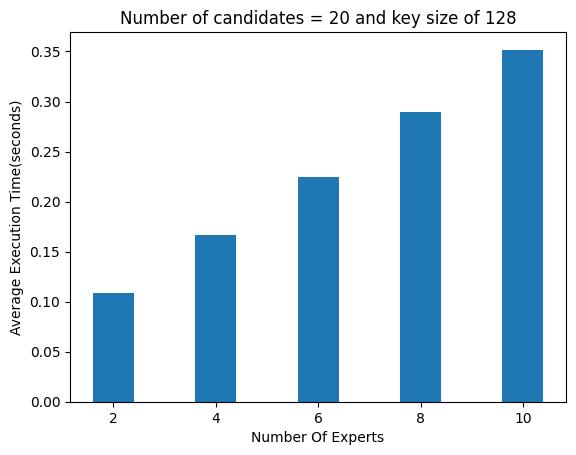

[0.10847409 0.16651617 0.22485438 0.2893665  0.3517712 ]


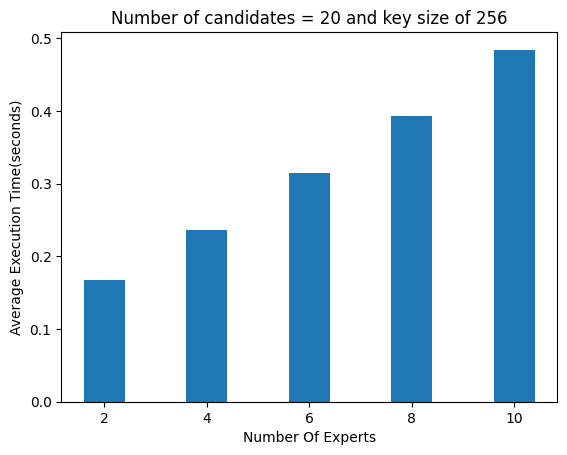

[0.1668879  0.23661849 0.31439716 0.3923929  0.48411068]


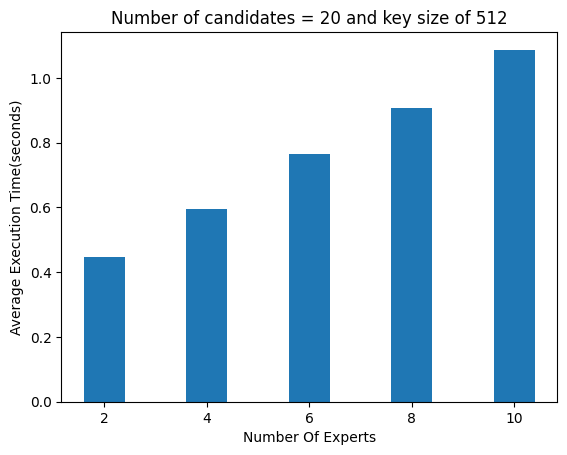

[0.4463703  0.5956633  0.7652558  0.90699494 1.0869495 ]
Stored 'F3Time' (list)


In [54]:
keys = [128,256,512]
F3Time = []
for i in range(0,3):
   time =  simulationHavingExpertsvariableCandidatesConst([2,4,6,8,10],20,"experts",keys[i])
   F3Time.append(time)
%store F3Time


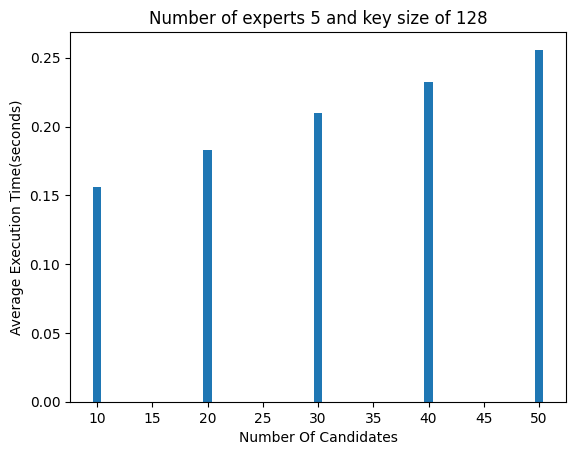

[0.15578732 0.18296066 0.20998318 0.23214214 0.25584218]


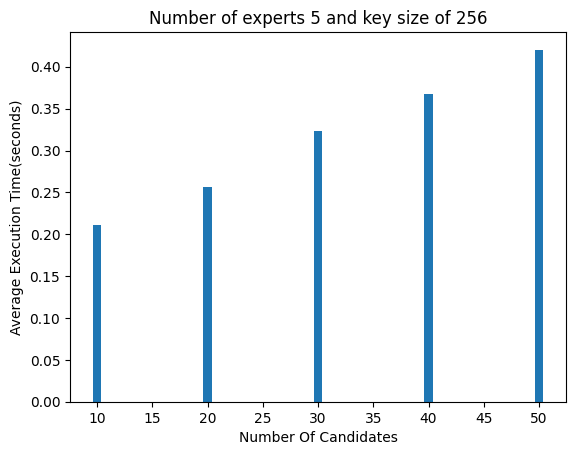

[0.2105813  0.2568459  0.32369462 0.3678916  0.4203462 ]


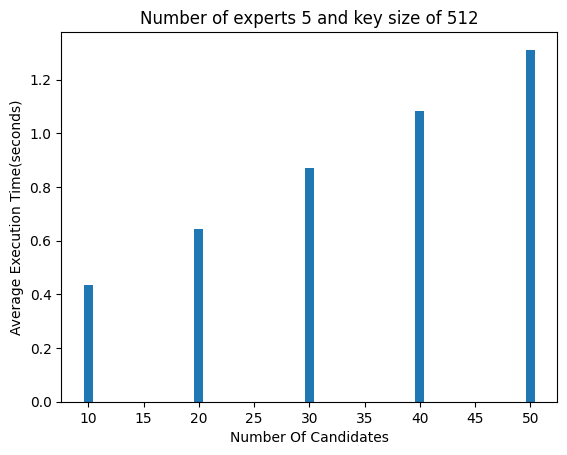

[0.43520817 0.6419575  0.87025297 1.0839794  1.3110349 ]
Stored 'F3TimeCandidateVariable' (list)


In [55]:
keys = [128,256,512]
F3TimeCandidateVariable = []
for i in range(0,3):
    time = simulationHavingExpertsConstCandidatesVariable(5,[10,20,30,40,50],"candidates",keys[i])
    F3TimeCandidateVariable.append(time)
%store F3TimeCandidateVariable

In [56]:
# z = 10
# timelist = []
# expertlist = [z + (i * 10) for i  in range(0,20)]
# print(expertlist)
# timelist = runSimulation(expertlist,20,"experts",256)
# plt.plot(expertlist,timelist)
